<a href="https://colab.research.google.com/github/mortezakhorsandnikoo/CNN/blob/main/architecture-style%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload
%autoreload 2
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [1]:
import math
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision 
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import os
import matplotlib.pyplot as plt
from torch.utils import data
from tqdm import tqdm

In [3]:
def get_model(model_name, parameters=None):
    return models.__dict__[model_name](parameters)                   

In [26]:
#size of image in inception is 299*299
sz=299
batch_size = 100
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
path="D:/AI_Machinlearning/datasets/building/architectural-styles-dataset/"

In [7]:
train_dir = f"{path}train"
valid_dir=f"{path}valid"

In [8]:
os.listdir(train_dir)

['Achaemenid architecture',
 'American craftsman style',
 'American Foursquare architecture',
 'Ancient Egyptian architecture',
 'Art Deco architecture',
 'Art Nouveau architecture',
 'Baroque architecture',
 'Bauhaus architecture',
 'Beaux-Arts architecture',
 'Byzantine architecture',
 'Chicago school architecture',
 'Colonial architecture',
 'Deconstructivism',
 'Edwardian architecture',
 'Georgian architecture',
 'Gothic architecture',
 'Greek Revival architecture',
 'International style',
 'Novelty architecture',
 'Palladian architecture',
 'Postmodern architecture',
 'Queen Anne architecture',
 'Romanesque architecture',
 'Russian Revival architecture',
 'Tudor Revival architecture']

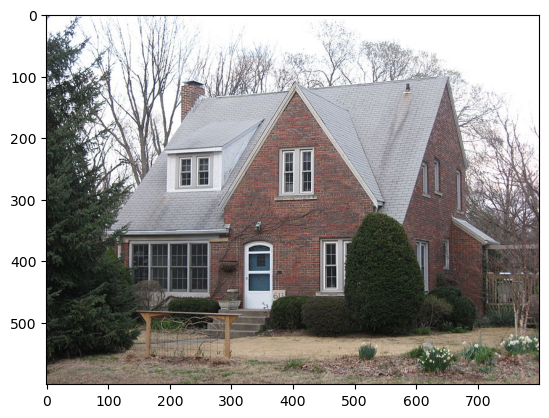

In [55]:
#show image from dataset
train_fnames=glob.glob(f"{train_dir}/*/*.jpg")
img=plt.imread(train_fnames[-1])
plt.imshow(img);

In [11]:
#transformation
trnfrm=transforms.Compose([
    transforms.Resize((sz , sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    
])

In [16]:
train_ds=datasets.ImageFolder(train_dir, transform= trnfrm)
valid_ds=datasets.ImageFolder(valid_dir , transform=trnfrm)

In [14]:
train_ds.class_to_idx

{'Achaemenid architecture': 0,
 'American Foursquare architecture': 1,
 'American craftsman style': 2,
 'Ancient Egyptian architecture': 3,
 'Art Deco architecture': 4,
 'Art Nouveau architecture': 5,
 'Baroque architecture': 6,
 'Bauhaus architecture': 7,
 'Beaux-Arts architecture': 8,
 'Byzantine architecture': 9,
 'Chicago school architecture': 10,
 'Colonial architecture': 11,
 'Deconstructivism': 12,
 'Edwardian architecture': 13,
 'Georgian architecture': 14,
 'Gothic architecture': 15,
 'Greek Revival architecture': 16,
 'International style': 17,
 'Novelty architecture': 18,
 'Palladian architecture': 19,
 'Postmodern architecture': 20,
 'Queen Anne architecture': 21,
 'Romanesque architecture': 22,
 'Russian Revival architecture': 23,
 'Tudor Revival architecture': 24}

In [20]:
print(len(train_ds) , len(valid_ds))

8110 750


In [23]:
train_dl=torch.utils.data.DataLoader(train_ds , batch_size=batch_size , shuffle=True )
valid_dl=torch.utils.data.DataLoader(valid_ds , batch_size= batch_size , shuffle = True)

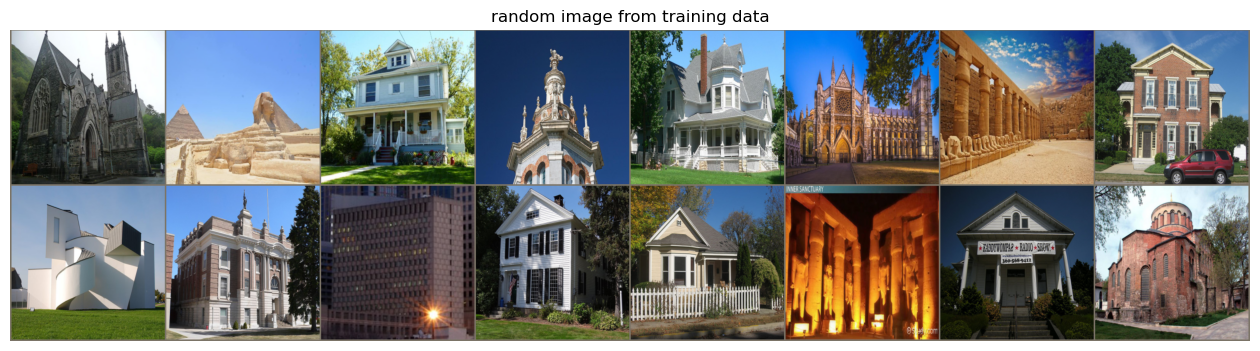

In [57]:
#show the image augmented
inputs , targets=next(iter(train_dl))
out=torchvision.utils.make_grid(inputs , padding=3)
title="random image from training data"
inp = out.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.figure(figsize=(16,12))
plt.imshow(inp)
plt.axis('off')
if title is not None:
        plt.title(title)

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\nikoo/.cache\torch\hub\v0.10.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\nikoo/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|███████████████████████████████████████████████████████████████████████████████| 104M/104M [00:36<00:00, 3.00MB/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [41]:
for param in model.parameters():
    param.requires_grad=False
    
model.fc=nn.Linear(2048, 25)

model=model.to(device)



In [28]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [31]:
#train
num_epochs=4
losess=[]
for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dl):
        inputs=inputs.to(device)
        targets=targets.to(device)
        #forward pass
        outputs=model(inputs)

        #loss
        loss=criterion(outputs , targets)
        losess.append(loss.item())

        #backwards
        optimizer.zero_grad()
        loss.backward()

        #update parameters
        optimizer.step()

        #report
        if(i+1)%50==0:
              print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                      % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/ 4], Step [ 50/ 81], Loss: 0.5181
Epoch [ 1/ 4], Step [100/ 81], Loss: 0.4602
Epoch [ 1/ 4], Step [150/ 81], Loss: 0.8547
Epoch [ 1/ 4], Step [200/ 81], Loss: 0.3567
Epoch [ 1/ 4], Step [250/ 81], Loss: 0.6031
Epoch [ 1/ 4], Step [300/ 81], Loss: 0.6475
Epoch [ 1/ 4], Step [350/ 81], Loss: 0.9134
Epoch [ 1/ 4], Step [400/ 81], Loss: 1.0196
Epoch [ 1/ 4], Step [450/ 81], Loss: 1.0359
Epoch [ 1/ 4], Step [500/ 81], Loss: 0.7168
Epoch [ 2/ 4], Step [ 50/ 81], Loss: 0.4519
Epoch [ 2/ 4], Step [100/ 81], Loss: 0.7260
Epoch [ 2/ 4], Step [150/ 81], Loss: 0.7002
Epoch [ 2/ 4], Step [200/ 81], Loss: 0.6801
Epoch [ 2/ 4], Step [250/ 81], Loss: 0.9501
Epoch [ 2/ 4], Step [300/ 81], Loss: 0.6313
Epoch [ 2/ 4], Step [350/ 81], Loss: 0.9371
Epoch [ 2/ 4], Step [400/ 81], Loss: 0.9097
Epoch [ 2/ 4], Step [450/ 81], Loss: 0.9133
Epoch [ 2/ 4], Step [500/ 81], Loss: 0.8497
Epoch [ 3/ 4], Step [ 50/ 81], Loss: 0.8428
Epoch [ 3/ 4], Step [100/ 81], Loss: 0.9389
Epoch [ 3/ 4], Step [150/ 81], L

In [32]:
def evaluate_model(model, dataloader, device):
    model.eval()               # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [33]:
evaluate_model(model, valid_dl, device)

accuracy: 53.07


In [34]:
evaluate_model(model, train_dl, device)

accuracy: 80.01
